In [1]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
#from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier
# df1 = pd.read_csv('balanced_group_stratified_fold_0.csv')
# df2 = pd.read_csv('balanced_group_stratified_fold_1.csv')
# df3 = pd.read_csv('balanced_group_stratified_fold_2.csv')
# df4 = pd.read_csv('balanced_group_stratified_fold_3.csv')
# df5 = pd.read_csv('balanced_group_stratified_fold_4.csv')

In [8]:
all_dfs = [df1, df2, df3, df4, df5]  # or load from a list
combined_df = pd.concat(all_dfs, ignore_index=True)

In [9]:
combined_df.shape

(651696, 26)

In [10]:
# 2. Drop duplicates if necessary
combined_df = combined_df.drop_duplicates()

In [11]:
combined_df = combined_df.drop(columns=['Test'])

In [12]:
combined_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.784110,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.683949,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.327514,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.347273,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.337194,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.806674,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.749625,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.741463,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.730336,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267


In [13]:
# 3. Re-split by group while preserving class balance
# GroupShuffleSplit doesn't balance classes itself, so we implement a custom version
def balanced_group_split(df, group_col, label_col, test_size=0.2, random_state=42):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    labels = df[label_col]
    
    # Use splitter to get train/test group indices
    for train_idx, test_idx in splitter.split(df, labels, groups):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        break

    # Optional: Rebalance classes in training and testing (downsample majority)
    def balance(df):
        df_pos = df[df[label_col] == 1]
        df_neg = df[df[label_col] == 0]
        n = min(len(df_pos), len(df_neg))
        return pd.concat([df_pos.sample(n, random_state=42), df_neg.sample(n, random_state=42)])

    train_df_balanced = balance(train_df)
    test_df_balanced = balance(test_df)

    # Add 'Test' column
    df['Test'] = False
    df.loc[test_df_balanced.index, 'Test'] = True
    return df

In [14]:
# 4. Apply the function to get new train/test assignment
final_df = balanced_group_split(combined_df, group_col='group_id', label_col='Same_Complex')


In [15]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [23]:
# final_df.to_csv('final_train_test_df.csv', index=False)

In [16]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [17]:
# FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
#        'scGPT_pancancer_embeddings_Cosine_Similarity',
#        'scGPT_lung_embeddings_Cosine_Similarity',
#        'scGPT_heart_embeddings_Cosine_Similarity',
#        'scGPT_brain_embeddings_Cosine_Similarity',
#        'scGPT_kidney_embeddings_Cosine_Similarity',
#        'scGPT_human_embeddings_Cosine_Similarity',
#        'GF-6L30M_HUMANemb_Cosine_Similarity',
#        'GF-20L95M_HUMANemb_Cosine_Similarity',
#        'GF-12L95M_HUMANemb_Cosine_Similarity',
#        'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
#        'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']


LABEL = ['Same_Complex']


In [18]:
FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

X = final_df[FEATURES]  # use your feature columns
y = final_df['Same_Complex']   # binary labels

X_train = X[~final_df['Test']]
y_train = y[~final_df['Test']]
X_test = X[final_df['Test']]
y_test = y[final_df['Test']]

In [3]:
FEATURES_og = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

FEATURES = ['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities',
       'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities',
       'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation']
mapper = dict(zip(FEATURES, FEATURES_og))
import pandas as pd
# X_full = pd.read_pickle("/home/ubuntu/full_dataset.pkl")[FEATURES].dropna()
# X_full.rename(columns=mapper, inplace=True)

In [37]:
pd.read_pickle("/home/ubuntu/full_dataset.pkl").columns

Index(['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities', 'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities', 'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation', 'Same_Complex'],
      dtype='object')

In [36]:
gene_ab = pd.read_pickle("/home/ubuntu/full_dataset.pkl").dropna()[['GeneAB']].to_list()

KeyError: "None of [Index(['GeneAB'], dtype='object')] are in the [columns]"

In [20]:
X_full

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
949027,0.063506,0.135321,0.125535,0.135128,0.383622,0.079211,0.235762,0.549340,0.188242,0.876189,0.879979,0.841622,0.116782
949028,-0.056565,0.079216,-0.021724,0.012198,0.222155,-0.051431,0.163293,0.393251,0.173845,0.779322,0.793168,0.762249,0.126619
949029,0.116124,0.308463,0.087753,0.112959,0.410780,0.055358,0.228007,0.585679,0.394791,0.899145,0.883349,0.825831,0.230485
949030,0.016978,0.058653,-0.049605,-0.008472,0.003432,-0.041763,-0.000696,0.347202,0.097802,0.738388,0.803293,0.789023,0.220536
949031,-0.031810,0.006320,-0.091508,-0.121315,-0.185753,-0.089556,-0.130848,0.347644,0.157392,0.742027,0.780049,0.778803,0.246139
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200776377,-0.110339,0.086440,0.034659,0.114352,0.038629,0.056565,0.094981,0.315341,0.108741,0.789531,0.840061,0.791421,0.154140
200776434,-0.034737,0.127792,-0.004790,0.008433,0.048624,-0.031635,0.063980,0.364127,0.127619,0.752806,0.793549,0.798082,0.319412
200776892,-0.001384,-0.010163,0.030453,0.046065,-0.061751,0.049211,-0.005287,0.405193,0.131710,0.824809,0.852520,0.815836,0.349904
200776899,-0.035554,-0.046015,-0.033491,0.045953,0.009507,0.009540,0.062917,0.283855,0.194667,0.821454,0.861418,0.817727,0.339114


In [21]:
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer
import numpy as np

class ManualStackingSGD(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 rf_params=None,
                 sgd_params=None,
                 norm='l1'):
        self.rf_params = rf_params or {
            'bootstrap': True,
            'criterion': "entropy",
            'max_features': 0.45,
            'min_samples_leaf': 3,
            'min_samples_split': 2,
            'n_estimators': 100,
            'random_state': 42
        }
        self.sgd_params = sgd_params or {
            'alpha': 0.01,
            'eta0': 0.01,
            'fit_intercept': False,
            'l1_ratio': 0.75,
            'learning_rate': "constant",
            'loss': "squared_hinge",
            'penalty': "elasticnet",
            'power_t': 0.5,
            'random_state': 42
        }
        self.norm = norm

        self.rf = RandomForestClassifier(**self.rf_params)
        self.sgd = SGDClassifier(**self.sgd_params)
        self.normalizer = Normalizer(norm=self.norm)

    def fit(self, X, y):
        self.rf.fit(X, y)
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.fit_transform(X_stacked)
        self.sgd.fit(X_norm, y)
        return self

    def predict(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.predict(X_norm)

    def decision_function(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.decision_function(X_norm)

def get_model_outputs(model, X_train, y_train, X_full):

    print('fitting')
    model.fit(X_train, y_train)

    # X_test should be the whole dataset here
    
    print('Running predictions:')
    print('Outputs:')
    outputs = {
        'model': model,
        'predictions': model.predict(X_full)
    }

    print('Finished generating predictions')
    print(outputs)

    print('Predict probabilities starting')
    if hasattr(model, "predict_proba"):
        print('getting probabilities')
        outputs['probabilities'] = model.predict_proba(X_full)[:, 1]
    else:
        print('no probs available')
        outputs['probabilities'] = None

    if hasattr(model, "decision_function"):
        print('getting decision scores')
        outputs['decision_scores'] = model.decision_function(X_full)
    else:
        print('no decision scores available')
        outputs['decision_scores'] = None

    return outputs



def get_model_outputs(model, X_train, y_train, X_full, batch_size=100000):
    model.fit(X_train, y_train)
    
    # Batch predictions to reduce memory usage
    y_pred_full = []
    y_proba_full = []

    num_batches = (len(X_full) + batch_size - 1) // batch_size  # Ceiling division

    for i in tqdm(range(0, len(X_full), batch_size), desc="Batch predicting", total=num_batches):
        X_batch = X_full[i:i + batch_size]
        preds = model.predict(X_batch)
        probs = model.predict_proba(X_batch)[:, 1]
        y_pred_full.append(preds)
        y_proba_full.append(probs)
    
    y_pred_full = np.concatenate(y_pred_full)
    y_proba_full = np.concatenate(y_proba_full)
    
    return {
        "model": model,
        "predictions": y_pred_full,
        "probabilities": y_proba_full
    }

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  
from sklearn.metrics import average_precision_score
# models = {
#         "Logistic Regression": LogisticRegression(max_iter=10000),
#         "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
#         "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
#         "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42),
#         "TPOT Gradient Boosting": gb_exported_pipeline, 
#         "TPOT Stacked RF SGD":  ManualStackingSGD()
#     }

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
}

In [27]:
all_model_results = {}

for name, model in tqdm(models.items(), desc="Fitting models"):
    print(name)
    try:
        result = get_model_outputs(model, X_train, y_train, X_full)
        all_model_results[name] = result
    except Exception as e:
        print(f"⚠️ Error with model '{name}': {e}")


Fitting models:   0%|          | 0/1 [00:00<?, ?it/s]

Random Forest



Fitting models: 100%|██████████| 1/1 [05:03<00:00, 303.79s/it]


In [28]:
len(all_model_results['Random Forest']['predictions'])

171115111

In [48]:
len(all_model_results['Logistic Regression']['predictions'])

14778

In [49]:
X_test

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
1,0.102524,0.103210,0.021262,0.010275,-0.024047,-0.033343,0.039581,0.366329,0.133535,0.683949,0.752542,0.745347,0.271149
20,-0.027582,0.183124,0.029311,-0.041216,0.020799,-0.016564,0.054325,0.434522,0.172853,0.795610,0.867047,0.851364,0.277557
22,0.133149,0.351443,0.045643,0.191658,0.032756,-0.009282,0.269301,0.465624,0.273476,0.810034,0.861912,0.836435,0.082435
28,0.055049,0.226153,0.022539,0.022190,0.206509,-0.018174,0.105206,0.533805,0.395045,0.827750,0.848891,0.780006,0.108920
33,-0.128032,-0.046387,-0.055148,-0.058276,0.090501,-0.063518,-0.005909,0.092124,0.227963,0.616886,0.651518,0.620652,0.182555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651614,0.117881,0.279793,-0.001514,-0.037940,0.261033,-0.025200,0.253424,0.508984,0.271296,0.827297,0.878903,0.801910,0.264942
651626,0.059294,0.011478,-0.035961,-0.042729,0.150184,-0.049927,0.071419,0.303448,0.096078,0.777399,0.844531,0.790319,0.320869
651639,0.036172,-0.049047,-0.040461,-0.017040,0.078815,-0.005500,-0.030646,0.231340,0.137182,0.719991,0.756183,0.646996,0.028505
651653,-0.013912,0.087307,0.028691,0.013662,0.054169,0.013986,0.103741,0.321201,0.032982,0.823486,0.854517,0.844332,0.182368


In [29]:
for mod in list(all_model_results.keys()):
    print(mod)

Random Forest


In [30]:
import pickle

with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(all_model_results, f)
    

In [2]:
import pickle

with open('all_model_results.pkl', 'rb') as f:
    all_model_results = pickle.load(f)

In [4]:
#test_df = final_df[final_df['Test']==True].copy()

X_full = pd.read_pickle("/home/ubuntu/full_dataset.pkl").dropna()
X_full.rename(columns=mapper, inplace=True)
for mod in list(all_model_results.keys()):
    for p in ['predictions', 'probabilities']:
        col_name = f'{mod} {p}'
        X_full[col_name] = all_model_results[mod][p]
    #print(all_model_results[mod].keys())
    

In [39]:
X_full.columns

Index(['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Same_Complex',
       'GeneAB', 'Random Forest predictions', 'Random Forest probabilities'],
      dtype='object')

<Axes: >

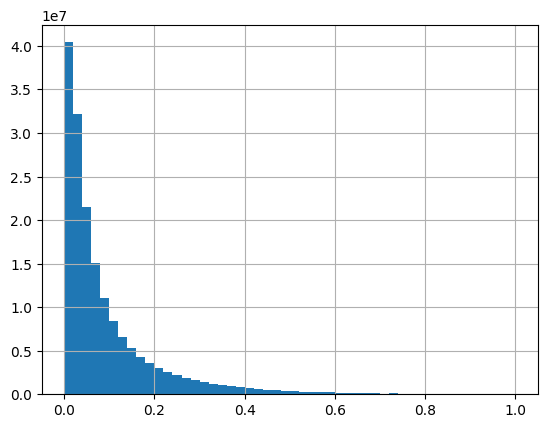

In [5]:
X_full['Random Forest probabilities'].hist(bins=50)

<Axes: >

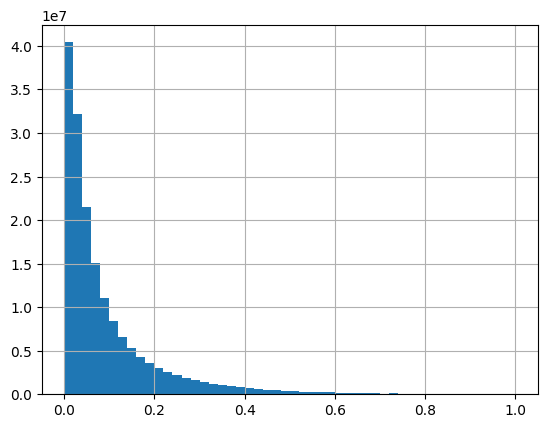

In [40]:
X_full['Random Forest probabilities'].hist(bins=50)

In [50]:
X_full[(X_full['Random Forest probabilities']>=0.99)&(X_full['Same_Complex']==1)]#['Random Forest probabilities']#.hist(bins=50)

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
1704555,0.201559,0.408497,0.418062,0.195187,0.041542,0.317344,0.032072,0.417977,0.335313,0.104717,0.769512,0.812227,0.785746,-0.054507,1,PSMD4_PSMD13,1,1.00
1704560,0.202372,0.360924,0.361415,0.206780,0.093870,0.348701,0.094190,0.360967,0.185893,0.133557,0.735777,0.790552,0.772209,0.176834,1,PSMD4_PSMB5,1,1.00
1704561,0.240474,0.458153,0.380647,0.175263,0.078085,0.269674,0.044079,0.380412,0.131553,0.117074,0.779008,0.815456,0.774087,-0.035015,1,PSMD4_PSMB4,1,1.00
1705533,0.257579,0.332245,0.387781,0.121601,0.018557,0.139786,0.047908,0.387813,0.140880,0.105430,0.758090,0.813953,0.759433,0.311855,1,PSMD4_PSMD6,1,1.00
1705578,0.172112,0.325798,0.354748,0.141956,0.089904,0.389848,0.060283,0.355155,0.650441,0.153728,0.769024,0.810652,0.860990,0.453318,1,PSMD4_PSMD7,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197710349,0.057965,0.085900,0.117496,0.000634,0.010525,-0.009662,0.004212,0.117083,0.327813,0.072753,0.740908,0.816693,0.812675,0.452124,1,STT3B_DDOST,1,1.00
197712341,0.166522,0.167243,0.261212,0.078116,0.078067,0.090810,0.041713,0.261042,0.254289,0.290924,0.764473,0.794030,0.795802,0.417123,1,STT3B_RPN2,1,1.00
197713488,-0.038323,0.048506,0.134203,-0.049437,0.084647,0.042778,-0.003146,0.133460,0.292791,0.023376,0.710836,0.800634,0.778411,0.402587,1,STT3B_TUSC3,1,0.99
198219119,0.083046,0.080239,0.015837,0.043744,0.013420,-0.139327,-0.022617,0.015780,0.386818,0.203508,0.749740,0.820959,0.830008,0.394768,1,SMARCD2_SMARCA2,1,1.00


<Axes: >

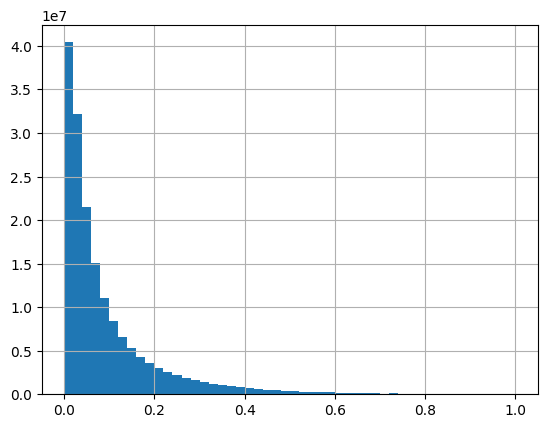

In [55]:
X_full[X_full['Same_Complex']==0]['Random Forest probabilities'].hist(bins=50)

<Axes: >

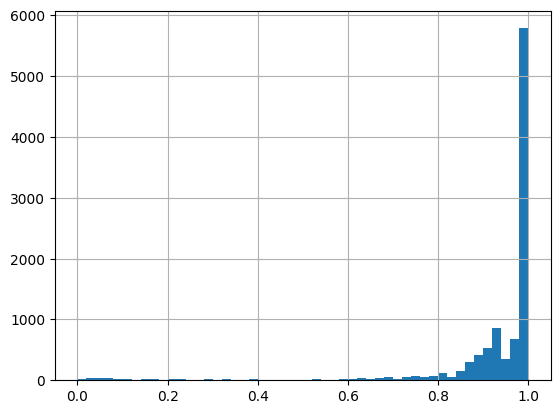

In [56]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].hist(bins=50)

In [53]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].median()

0.99

In [54]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].mean()

0.9212860659773511

In [43]:
def plot_roc_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('full_train_test_roc.png',dpi=300)
    plt.show()

def plot_pr_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            ap = average_precision_score(y_test, y_score)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig('full_train_test_auprc.png', dpi=300)
    plt.show()

In [36]:
y_test

1         1
20        1
22        1
28        1
33        1
         ..
651614    0
651626    0
651639    0
651653    0
651688    0
Name: Same_Complex, Length: 14778, dtype: int64

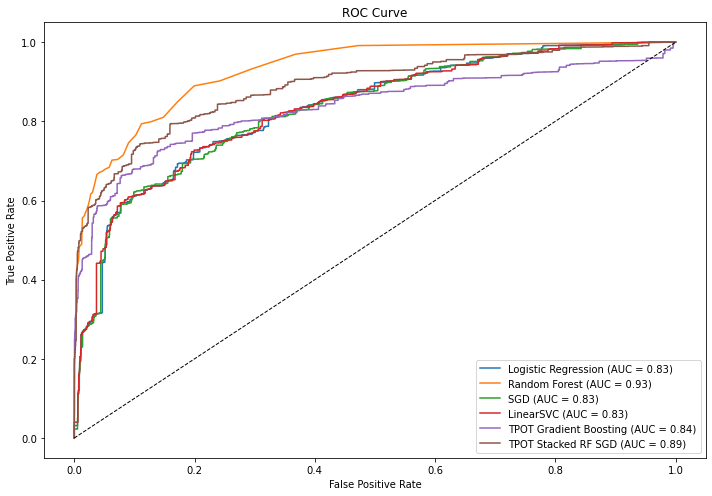

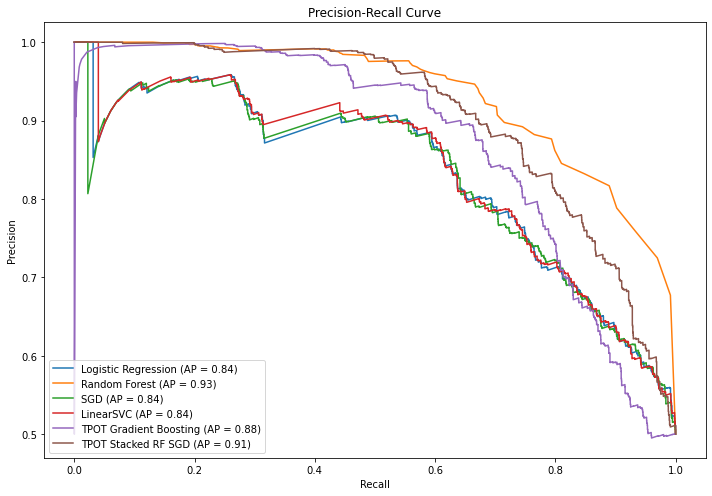

In [44]:
plot_roc_curves(all_model_results, y_test)
plot_pr_curves(all_model_results, y_test)

In [96]:
test_df.columns

Index(['Gene_B', 'complex_id_B', 'Gene_A', 'complex_id_A', 'global_index',
       'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Gene_1',
       'Gene_2', 'pair_id', 'pairwise_label', 'Same_Complex', 'group_id',
       'Test', 'Logistic Regression predictions',
       'Logistic Regression probabilities',
       'Logistic Regression decision_scores', 'Random Forest predictions',
   

In [109]:
RF = X_full[["GeneAB", "Random Forest probabilities", "Random Forest predictions", "Same_Complex"]].copy()

In [110]:
RF["Prob_Bin"] = pd.cut(RF["Random Forest probabilities"], bins=5, labels=False, include_lowest=True)

In [111]:
RF.sample(n=10155)

,GeneAB,Random Forest probabilities,Random Forest predictions,Same_Complex,Prob_Bin
47002274,PDP2_EXD2,0.37,0,0,1
76180662,TTLL8_GSDMA,0.05,0,0,0
194113558,ZNF813_SPRY1,0.08,0,0,0
2552616,PRDM1_MTMR4,0.05,0,0,0
184889330,NLRP10_EFCAB11,0.05,0,0,0
...,...,...,...,...,...
63252479,GFOD1_SNCA,0.05,0,0,0
32358826,KIAA2013_NTN1,0.13,0,0,0
140274449,POPDC3_KBTBD8,0.12,0,0,0
62626866,SPTAN1_ACAN,0.05,0,0,0


In [112]:
rf = pd.concat([RF[RF['Same_Complex']==1], RF[RF['Same_Complex']==0].sample(n=75000)])

In [113]:
# Number of pairs to sample per bin
N = 5

sampled_pairs = (
    rf.groupby("Prob_Bin")
    .apply(lambda x: x.sample(min(len(x), N), random_state=42))
    .reset_index(drop=True)
)

In [114]:
# Number of pairs to sample per bin
N = 5

sampled_pairs_OG = (
    RF.groupby("Prob_Bin")
    .apply(lambda x: x.sample(min(len(x), N), random_state=42))
    .reset_index(drop=True)
)

In [115]:
sampled_pairs['Same_Complex'].value_counts()

0    19
1     6
Name: Same_Complex, dtype: int64

In [116]:
sampled_pairs

,GeneAB,Random Forest probabilities,Random Forest predictions,Same_Complex,Prob_Bin
0,ZNF713_DIPK1C,0.18,0,0,0
1,LGR5_OIP5,0.09,0,0,0
2,KRTAP21-1_RAD18,0.00,0,0,0
3,XIRP2_ASH2L,0.02,0,0,0
4,ROPN1B_ARHGEF2,0.01,0,0,0
5,LRRCC1_SUV39H2,0.22,0,0,1
6,ATP6V1G2_LY6E,0.23,0,0,1
7,LIM2_ARSA,0.35,0,0,1
8,RNF19B_NFAM1,0.22,0,0,1
9,SLC37A4_PRIM1,0.39,0,0,1


In [117]:
from Bio import Entrez, SeqIO
import time

Entrez.email = "brianna.flynn@utexas.edu"  # Required for NCBI Entrez access

def fetch_protein_fasta_from_gene(gene_name, organism="Homo sapiens"):
    try:
        search_handle = Entrez.esearch(
            db="protein",
            term=f"{gene_name}[Gene Name] AND {organism}[Organism]",
            retmode="xml",
            retmax=1
        )
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            return None

        protein_id = search_results["IdList"][0]
        fetch_handle = Entrez.efetch(
            db="protein",
            id=protein_id,
            rettype="fasta",
            retmode="text"
        )
        fasta_data = fetch_handle.read()
        fetch_handle.close()
        return fasta_data.strip()
    except Exception as e:
        print(f"Error retrieving {gene_name}: {e}")
        return None

# Run the test
test_fasta = fetch_protein_fasta_from_gene("SRP68")
print(test_fasta)

>NP_001247432.1 signal recognition particle subunit SRP68 isoform 3 [Homo sapiens]
MLSECRDAIQVVREELKPDQKQRDYILEGEPGKVSNLQYLHSYLTYIKLSTAIKRNENMAKGLQRALLQQ
QPEDDSKRSPRPQDLIRLYDIILQNLVELLQLPGLEEDKAFQKEIGLKTLVFKAYRCFFIAQSYVLVKKW
SEALVLYDRVLKYANEVNSDAGAFKNSLKDLPDVQELITQVRSEKCSLQAAAILDANDAHQTETSSSQVK
DNKPLVERFETFCLDPSLVTKQANLVHFPPGFQPIPCKPLFFDLALNHVAFPPLEDKLEQKTKSGLTGYI
KGIFGFRS


In [118]:
sampled_pairs[['Gene_A', 'Gene_B']] = sampled_pairs['GeneAB'].str.split('_', expand=True)

In [119]:
sampled_pairs.shape

(25, 7)

In [120]:
len(unique_genes)

100

In [121]:
unique_genes = pd.unique(sampled_pairs[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fasta = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI


In [122]:
sampled_pairs_OG[['Gene_A', 'Gene_B']] = sampled_pairs_OG['GeneAB'].str.split('_', expand=True)
unique_genes = pd.unique(sampled_pairs_OG[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fastaOG = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fastaOG[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI


In [123]:
list(gene_to_fastaOG.values())[0]

'>NP_001139675.1 RAS guanyl-releasing protein 4 isoform c [Homo sapiens]\nMNRKDSKRKSHQECTGKIGGRGRPRQVRRHKTCPSPREISKVMASMNLGLLSEGGCSEDELLEKCIQSFD\nSAGSLCHEDHMLNMVLAMHSWVLPSADLAARLLTSYQKATGDTQELRRLQICHLVRYWLMRHPEVMHQDP\nQLEEVIGRFWATVAREGNSAQRRLGDSSDLLSPGGPGPPLPMSSPGLGKKRKVSLLFDHLETGELAQHLT\nYLEFRSFQAITPQDLRSYVLQGSVRGCPALEGSVGLSNSVSRWVQVMVLSRPGPLQRAQVLDKFIHVAQR\nLHQLQNFNTLMAVTGGLCHSAISRLKDSHAHLSPDSTKLSLDLFYTEDEIYELSYAREPRCPKSLPPSPF\nNAPLVVEWAPGVTPKPDRVTLGRHVEQLVESVFKNYDPEGRGTISQEDFERLSGNFPFACHGLHPPPRQG\nRGSFSREELTGYLLRASAICSKLGLAFLHTFHEVTFRKPTFCDSCSGFLWGVTKQGYRCRECGLCCHKHC\nRDQVKVECKKRPGAKGDAGPPGAPVPSTPAPHASCGSEENHSYTLSLEPETGCQLRHAWTQTESPHPSWE\nTDTVPCPVMDPPSTASSKLDS'

In [124]:
gene_to_fasta_dict = {}
for key, val in gene_to_fasta.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fasta_dict[key] = f'>{key}\n{sequence}'

gene_to_fasta_dict

{'ZNF713': '>ZNF713\nMPSQNAVFSQEGNMEEEEMNDGSQMVRSQESLTFQDVAVDFTREEWDQLYPAQKNLYRDVMLENYRNLVA\nLGYQLCKPEVIAQLELEEEWVIERDSLLDTHPDGENRPEIKKSTTSQNISDENQTHEMIMERLAGDSFWY\nSILGGLWDFDYHPEFNQENHKRYLGQVTLTHKKITQERSLECNKFAENCNLNSNLMQQRIPSIKIPLNSD\nTQGNSIKHNSDLIYYQGNYVRETPYEYSECGKIFNQHILLTDHIHTAEKPSECGKAFSHTSSLSQPQMLL\nTGEKPYKCDECGKRFSQRIHLIQHQRIHTGEKPFICNGCGKAFRQHSSFTQHLRIHTGEKPYKCNQCGKA\nFSRITSLTEHHRLHTGEKPYECGFCGKAFSQRTHLNQHERTHTGEKPYKCNECGKAFSQSAHLNQHRKIH\nTREKLCEYKCEQTVRHSPSFSST',
 'DIPK1C': '>DIPK1C\nMARAAGARGPAGWCRRRGRCGRGTLLAFAAWTAGWVLAAALLLRAHPGVLSERCTDEKSRRILAALCQDY\nQGGTLAGDLCEDLCVAGELLFQRCLHYNRGKKVLQADWRGRPVVLKSKEEAFSSFPPLSLLEEEAGEGGQ\nDMPEAELLLMVAGEVKSALGLELSNSSLGPWWPGRRGPRWRGQLASLWALLQQEEYVYFSLLQDLSPHVL\nPVLGSCGHFYAVEFLAAGSPHHRALFPLDRAPGAPGGGQAKAISDIALSFLDMVNHFDSDFSHRLHLCDI\nKPENFAIRSDFTVVAIDVDMAFFEPKMREILEQNCTGDEDCNFFDCFSRCDLRVNKCGAQRVNNNLQVIC\nDKIFRHWFSAPLKSSAVSFQLQLQLQEAVQECADPGVPSGNTRRAASSVFWKLRQLLQATLRELQEAEK',
 'LGR5': '>LGR5\nMDTSRLGVLLSLPVLLQLATGGSSPRSGVLLRGCPTHCHCEPDGRMLLRVD

In [125]:
gene_to_fastaOG_dict = {}
for key, val in gene_to_fastaOG.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fastaOG_dict[key] = f'>{key}\n{sequence}'

In [126]:
import os
output_dir = "colabfold_inputs"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs.iterrows():
    fasta_a = gene_to_fasta_dict.get(row["Gene_A"])
    fasta_b = gene_to_fasta_dict.get(row["Gene_B"])

    if fasta_a and fasta_b:
        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(fasta_a + "\n" + fasta_b + "\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")



In [127]:
import os
output_dir = "colabfold_inputsOG"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs_OG.iterrows():
    fasta_a = gene_to_fastaOG_dict.get(row["Gene_A"])
    fasta_b = gene_to_fastaOG_dict.get(row["Gene_B"])

    if fasta_a and fasta_b:
        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(fasta_a + "\n" + fasta_b + "\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")

In [123]:
test_df.drop(columns=['Gene_1', 'Gene_2', 'Test'], inplace=True)

In [124]:
test_df.to_csv('test_dataset_with_model_probs_preds_decision-scores.csv',index=False)

In [126]:
RF.to_csv('binned_randomforest_probs_decision-scores.csv', index=False)

In [99]:
X_full[['GeneAB', 'Random Forest probabilities', 'Random Forest predictions']].sample(n=1711151).to_csv('TESTSAMPLESIZE.csv')

In [97]:
171115111 / 100

1711151.11

In [100]:
X_full[X_full['Correlation']!=1.0]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
949027,0.063506,0.135321,0.234719,0.125535,0.135128,0.383622,0.079211,0.235762,0.549340,0.188242,0.876189,0.879979,0.841622,0.116782,0,PYDC1_PYCR3,0,0.07
949028,-0.056565,0.079216,0.161900,-0.021724,0.012198,0.222155,-0.051431,0.163293,0.393251,0.173845,0.779322,0.793168,0.762249,0.126619,0,PYDC1_BAG3,0,0.00
949029,0.116124,0.308463,0.226987,0.087753,0.112959,0.410780,0.055358,0.228007,0.585679,0.394791,0.899145,0.883349,0.825831,0.230485,0,PYDC1_PXT1,0,0.06
949030,0.016978,0.058653,-0.002022,-0.049605,-0.008472,0.003432,-0.041763,-0.000696,0.347202,0.097802,0.738388,0.803293,0.789023,0.220536,0,PYDC1_PXK,0,0.03
949031,-0.031810,0.006320,-0.130927,-0.091508,-0.121315,-0.185753,-0.089556,-0.130848,0.347644,0.157392,0.742027,0.780049,0.778803,0.246139,0,PYDC1_PUM2,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200776377,-0.110339,0.086440,0.089373,0.034659,0.114352,0.038629,0.056565,0.094981,0.315341,0.108741,0.789531,0.840061,0.791421,0.154140,0,BCAT1_TMPRSS3,0,0.14
200776434,-0.034737,0.127792,0.063827,-0.004790,0.008433,0.048624,-0.031635,0.063980,0.364127,0.127619,0.752806,0.793549,0.798082,0.319412,0,BCAT1_TPP1,0,0.06
200776892,-0.001384,-0.010163,-0.005988,0.030453,0.046065,-0.061751,0.049211,-0.005287,0.405193,0.131710,0.824809,0.852520,0.815836,0.349904,0,BCAT1_ZNF20,0,0.03
200776899,-0.035554,-0.046015,0.062382,-0.033491,0.045953,0.009507,0.009540,0.062917,0.283855,0.194667,0.821454,0.861418,0.817727,0.339114,0,BCAT1_ZNF230,0,0.16


In [10]:
X_full.drop(columns=['Same_Complex'],inplace=True)

In [11]:
X_full.columns

Index(['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'GeneAB',
       'Random Forest predictions', 'Random Forest probabilities', 'Prob_Bin'],
      dtype='object')

In [6]:
X_full["Prob_Bin"] = pd.cut(X_full["Random Forest probabilities"], bins=5, labels=False, include_lowest=True)

In [14]:
df_init = X_full[X_full['Prob_Bin']==0]
for i in range(1, 5):
    
    df = X_full[X_full['Prob_Bin']==i].sample(n=100000, random_state=42)
    df_init = pd.concat([df_init, df])
    #df.sample(n=100000, random_state = 42).to_csv(f'full_dataset_probs_preds_100ksample_prob-bin-{i}.csv', index=False)

df_init.to_csv('full_dataset_probs_preds_500ksample_5-prob-bins.csv', index=False)

KeyboardInterrupt: 

In [134]:
X_full[X_full['Prob_Bin']==10]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin


In [16]:
X_full[['Gene_A', 'Gene_B']] = X_full['GeneAB'].str.split('_', expand=True)

In [17]:
cilia = pd.read_csv('ciliary_genes_humap.csv')

cilia['Gene_A'] = cilia['Gene'].to_list()
cilia['Gene_B'] = cilia['Gene'].to_list()

cilia

,Gene,Gene_A,Gene_B
0,AK7,AK7,AK7
1,AK8,AK8,AK8
2,AK9,AK9,AK9
3,ARMC2,ARMC2,ARMC2
4,ARMC3,ARMC3,ARMC3
...,...,...,...
77,TMEM231,TMEM231,TMEM231
78,TPPP3,TPPP3,TPPP3
79,TTC23L,TTC23L,TTC23L
80,TTC26,TTC26,TTC26


In [18]:
cilia_a = X_full.merge(cilia[['Gene_A']], on = 'Gene_A')

In [20]:
cilia_ab = cilia_a.merge(cilia[['Gene_B']], on = 'Gene_B')

In [22]:
cilia_ab.to_csv('cilia_humap_features.csv', index=False)

In [24]:
cmplx = pd.read_pickle('/home/ubuntu/complex_label.pkl')

In [26]:
cilia_ab_c = cilia_ab.merge(cmplx, on = 'GeneAB')

In [28]:
cilia_ab_c.to_csv('cilia_humap_features.csv', index=False)

In [32]:
cilia_ab_c[cilia_ab_c['Same_Complex']==1]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
1721,0.299345,0.409764,0.324771,0.219217,0.103579,0.264314,0.097743,0.326032,0.549215,0.265855,...,0.887978,0.792104,0.211387,RSPH4A_RSPH9,1,1.00,4,RSPH4A,RSPH9,1
2230,0.136145,0.352463,0.317294,0.108980,0.112843,0.280344,0.067156,0.317544,0.554594,0.253898,...,0.921747,0.899929,0.243697,TCTN2_TMEM231,1,0.98,4,TCTN2,TMEM231,1


<Axes: >

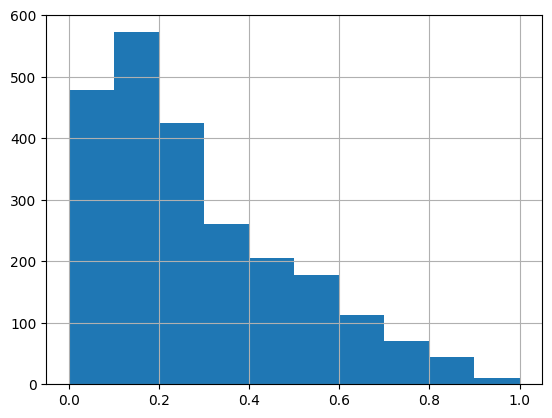

In [33]:
cilia_ab_c['Random Forest probabilities'].hist()

In [43]:
cilia_ab_c[cilia_ab_c['Random Forest probabilities']>=0.9]#.to_csv('top_ciliary_probabilties.csv')

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
131,0.280065,0.457387,0.344226,0.278140,0.105596,0.267543,0.048958,0.345802,0.602991,0.265112,...,0.893911,0.820210,0.182126,DNAH7_ARMC3,1,0.92,4,DNAH7,ARMC3,0
1017,0.209807,0.400355,0.350241,0.225984,0.098923,0.292140,0.080789,0.354788,0.592747,0.217169,...,0.883005,0.884360,0.257294,DNAH7_SPEF2,1,0.90,4,DNAH7,SPEF2,0
1181,0.186974,0.450345,0.424645,0.224743,0.109704,0.432221,0.040895,0.425352,0.588267,0.259274,...,0.876482,0.777081,0.340529,CFAP45_CFAP300,1,0.91,4,CFAP45,CFAP300,0
1344,0.325937,0.384749,0.429546,0.317125,0.165360,0.440951,0.126227,0.431846,0.594053,0.400239,...,0.879826,0.797378,0.304620,CIBAR2_DYDC2,1,0.90,4,CIBAR2,DYDC2,0
1404,0.208657,0.440549,0.380993,0.225661,0.109810,0.356503,0.055337,0.381691,0.562834,0.259723,...,0.864765,0.747805,0.104531,CFAP300_DYNLT4,1,0.96,4,CFAP300,DYNLT4,0
1411,0.198581,0.358456,0.375841,0.244173,0.112051,0.219069,0.060698,0.376790,0.384487,0.231769,...,0.824420,0.764203,0.126221,DPCD_DYNLT4,1,0.90,4,DPCD,DYNLT4,0
1423,0.256492,0.433497,0.385070,0.273415,0.143365,0.287377,0.059905,0.385902,0.549363,0.305910,...,0.864525,0.786964,0.395272,RSPH9_DYNLT4,1,0.92,4,RSPH9,DYNLT4,0
1583,0.215785,0.347286,0.374271,0.266259,0.107773,0.323266,0.037381,0.374705,0.534527,0.333650,...,0.877169,0.764525,0.552746,CFAP45_SPAG6,1,0.91,4,CFAP45,SPAG6,0
1721,0.299345,0.409764,0.324771,0.219217,0.103579,0.264314,0.097743,0.326032,0.549215,0.265855,...,0.887978,0.792104,0.211387,RSPH4A_RSPH9,1,1.00,4,RSPH4A,RSPH9,1
2230,0.136145,0.352463,0.317294,0.108980,0.112843,0.280344,0.067156,0.317544,0.554594,0.253898,...,0.921747,0.899929,0.243697,TCTN2_TMEM231,1,0.98,4,TCTN2,TMEM231,1


In [44]:
cilia_ab_c[cilia_ab_c['Random Forest probabilities']<=0.00]#.to_csv('bottom_ciliary_probabilities.csv')

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
327,0.018519,0.160493,0.036165,0.008527,0.015626,0.009171,-0.029753,0.036869,0.352743,0.120364,...,0.803138,0.712109,0.376991,C1orf87_CFAP298,0,0.0,0,C1orf87,CFAP298,0
351,-0.020388,0.161613,0.052781,0.069227,0.071969,0.112507,0.060433,0.052947,0.330282,0.168461,...,0.871615,0.779149,0.058686,NME9_CFAP298,0,0.0,0,NME9,CFAP298,0
900,0.109368,0.207321,0.060637,0.115682,0.040896,0.010421,0.017447,0.054397,0.412702,0.228846,...,0.848155,0.812411,0.413137,C7orf57_CDHR3,0,0.0,0,C7orf57,CDHR3,0
1016,-0.000481,0.270013,0.058789,0.092928,0.104051,-0.035231,0.056334,0.059317,0.495326,0.238916,...,0.851549,0.739738,0.504541,GAS2L2_SPEF2,0,0.0,0,GAS2L2,SPEF2,0
1490,0.108524,0.129088,0.032387,0.076643,0.005990,-0.008882,-0.031929,0.032741,0.376803,0.214399,...,0.828711,0.749206,0.398197,TTC23L_RFX3,0,0.0,0,TTC23L,RFX3,0
1652,-0.002709,0.296664,0.123984,0.032127,0.022442,0.058092,-0.006794,0.124872,0.653386,0.289308,...,0.859852,0.722583,0.358654,GAS2L2_SPAG17,0,0.0,0,GAS2L2,SPAG17,0
1901,0.088052,0.301318,-0.005400,0.046020,-0.000714,0.030132,-0.045118,-0.006626,0.465439,0.178628,...,0.841710,0.677836,-0.043601,CDHR3_TEKT4,0,0.0,0,CDHR3,TEKT4,0
1954,0.024450,0.063235,0.061013,-0.034428,0.013860,0.143567,-0.019773,0.058021,0.345693,0.243767,...,0.825804,0.762758,0.126442,ENO4_TPPP3,0,0.0,0,ENO4,TPPP3,0
1974,0.062120,0.190157,0.180763,0.071984,0.025940,0.247607,-0.005092,0.178541,0.435752,0.282280,...,0.835645,0.772723,0.041837,NEK5_TPPP3,0,0.0,0,NEK5,TPPP3,0
2316,-0.002740,0.334227,0.060353,0.054462,0.071801,-0.025880,0.023754,0.062888,0.631112,0.274459,...,0.875413,0.762721,0.301034,GAS2L2_DNAH7,0,0.0,0,GAS2L2,DNAH7,0
